## DSCI 100: GROUP PROJECT FINAL REPORT
 **Predicting Heart Disease in Hungary**

GROUP 10 - SECTION 007: Michelle Ho, Arian Afshari, Zidong Zhou, Kyle Wise

In [24]:
library(tidyverse)
library(tidymodels)
install.packages("corrplot")
library(corrplot)
library(rsample)
library(repr)

Updating HTML index of packages in '.Library'

Making 'packages.html' ...
 done



In [25]:
options(repr.matrix.max.rows = 6)
options(repr.plot.width=9, repr.plot.height=7)

### Introduction

**Background Information:**

One of the leading causes of death in Hungary are cardiovascular diseases (CVDs) (OECD and WHO, 2017). It constitutes approximately 52.4% of the main diagnoses underlying cause of death and 47.6% of the secondary diagnoses prior to death. Heart failure is a common result of CVDs. Several risk factors are known to be associated with CVDs; the most prominent among them are high blood pressure, high cholesterol levels, and smoking (CDC, 2022). Moreover, susceptibility to heart disease increases with age and other uncontrollable factors such as sex (McLaren, 2023).

As data science becomes progressively useful in analyzing and interpreting patient outcomes, we plan to use the k-nearest neighbors classification algorithm to predict angiographic disease status of CVDs. Our project will use the *Heart Disease* data set from the UCI Machine Learning Repository to build the model that will predict CVD diagnoses in presenting patients. The diagnosis of heart disease in the data set is defined as a binary label, whether the patient has the disease or not. The disease is present if there is greater than 50% diameter narrowing of any major blood vessels in a patient. Ie., if the value in the num parameter is 1, then more than 50% of the diameter of the major blood vessels are narrowing (Hungarian Institute of Cardiology, 1988). When blood vessels narrow, the heart does not receive the blood that it requries and thus, is considered heart disease.

The dataset that we will be using features 14 attributes of patients that will be examined to determine which are possible indicators of heart disease:
- Age
- Sex
- Chest pain type (cp); (1: typical angina, 2: atypical angina, 3: non-anginal pain, 4: asymptomatic)
- Resting blood pressure (trestbps); (mmHg upon admission to hospital)
- Serum cholestoral (chol); (mg/dl)
- Fasting blood sugar (fbs) > 120 mg/dl; (1: true; 0: false)
- Resting electrocardiographic results (restecg); (0: normal, 1: having ST-T wave abnormality (T wave inversions and/or ST elevation or depression of > 0.05 mV), 2: showing probable or definite left ventricular hypertrophy by Estes' criteria)
- Maximum heart rate achieved (thalach)
- Exercise induced angina (exang); (1: yes; 0: no)
- ST depression induced by exercise relative to rest (oldpeak)
- Slope of the peak exercise ST segment (slope); (1: upsloping, 2: flat, 3: downsloping)
- Number of major vessels (0-3) colored by flourosopy (ca)
- Presence of heart defect (thal): (3: normal; 6: fixed defect; 7: reversable defect)
- Diagnosis of heart disease (angiographic disease status) (num); (0: < 50% diameter narrowing, 1: > 50% diameter narrowing (the predicted attribute)

To determine which of these variables are suitable for classifying angiographic disease status, we decided to implement correlation analysis. First, we performed one-hot encoding on our categorical variables to create new columns that contain numerical variables representing those categorical ones. Subsequently, the relationships of these variables with the target variable were then mapped into a correlation matrix. The variables with relatively high pearson correlation coefficients will be chosen as indicators to predict the presence of heart disease in patients.

**Preliminary data wrangling:**

The seed was set such that the numbers used in the analysis are reasonably random. It also permits reproducibility such that the same results are obtained each time this program is run.


In [3]:
set.seed(3789)

The Heart Disease data set from the UCI Machine Learning Repository was loaded and all of the observations containing "?" were converted to NA. String values of "?" are difficult to work with because the functions that are used in this program disregard NA values. Moreover, the variables were mutated to their correct type. Numerical variables were converted to doubles (dbl), and categorical variables were converted to factors (fct).

In [4]:
heart_disease_data <- read_csv("https://archive.ics.uci.edu/ml/machine-learning-databases/heart-disease/processed.hungarian.data", 
                               col_names = c("age", "sex", "cp", "trestbps", "chol", "fbs","restecg", "thalach", "exang", "oldpeak",
                                             "slope", "ca", "thal", "num"))
heart_disease_data[heart_disease_data == "?"]<-NA
heart_disease_data

Rows: 294 Columns: 14
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (9): trestbps, chol, fbs, restecg, thalach, exang, slope, ca, thal
dbl (5): age, sex, cp, oldpeak, num

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,num
<dbl>,<dbl>,<dbl>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<dbl>,<chr>,<chr>,<chr>,<dbl>
28,1,2,130,132,0,2,185,0,0,NA,NA,NA,0
29,1,2,120,243,0,0,160,0,0,NA,NA,NA,0
29,1,2,140,NA,0,0,170,0,0,NA,NA,NA,0
⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮
56,1,4,155,342,1,0,150,1,3,2,NA,NA,1
58,0,2,180,393,0,0,110,1,1,2,NA,7,1
65,1,4,130,275,0,1,115,1,1,2,NA,NA,1


*Table 1. Glimpse of the Original Heart Disease Data*

In [5]:
# using mutate_if, the character (chr) columns that are supposedly numerical were selected and mutated to dbl,
# mutate_at was then used to mutate the chr columns that are supposedly categorical to fct

heart_disease_data <- heart_disease_data |>
    mutate_if(is.character, as.numeric) |>
    mutate_at(vars("sex", "cp", "fbs", "restecg", "exang", "ca", "thal", "num", "slope"), factor)
heart_disease_data

age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,num
<dbl>,<fct>,<fct>,<dbl>,<dbl>,<fct>,<fct>,<dbl>,<fct>,<dbl>,<fct>,<fct>,<fct>,<fct>
28,1,2,130,132,0,2,185,0,0,NA,NA,NA,0
29,1,2,120,243,0,0,160,0,0,NA,NA,NA,0
29,1,2,140,NA,0,0,170,0,0,NA,NA,NA,0
⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮
56,1,4,155,342,1,0,150,1,3,2,NA,NA,1
58,0,2,180,393,0,0,110,1,1,2,NA,7,1
65,1,4,130,275,0,1,115,1,1,2,NA,NA,1


*Table 2. Wrangled Heart Disease Data*

The wrangled *Heart Disease* data was then partitioned into training and testing sets with proportions of 75:25 respectively. To predict angiographic disease status, "num" has been selected as the class label. *Those that have a heart disease diagnoses will have a num value of 1, indicating that there is more than 50% blood vessels diameter narrowing. Those that do not have a heart disease diagnoses have a num value of 0, indicating that there is less than 50% blood vessels diameter narrowing.* The test data will be used in the exploratory data analysis to examine trends in the data and determine which variables are suitable as predictors. The test data is kept unused until the step of evaluating the model performance. This is to ensure that there is no positive bias when testing the accuracy of the model.

In [6]:
heart_disease_split <- initial_split(heart_disease_data, prop = 0.75, strata = num)
heart_disease_train <- training(heart_disease_split)
heart_disease_test <- testing(heart_disease_split)

**Exploratory data analysis using training data:**

Exploratory data analysis was performed to investigate the data and summarize its main characteristics. The proportion of patients with a diagnosis of heart disease (positive angiographic disease status) and the proportion of patients without in the training data were identified in Table 3. The code to evaluate the original data was to ensure that the proportions were preserved during the split; the split was indeed preserved. Table 4 reports the number of rows that have missing data which is when there is at least one NA in the observation. This was important information to consider because several parts of the program will not run with NA values; mode imputation will be used to change all of the NAs in factors to their mode later in this program (methods section). Lastly, a summary of the training data is reported in Table 5 which includes the mean, minimum, and maximum of the numerical variables in the data.

In [7]:
heart_disease_data_proportions <- heart_disease_data |>
                      group_by(diagnosis = num) |>
                      summarize(people = n()) |>
                      mutate(percent = 100*people/nrow(heart_disease_data))

heart_disease_train_proportions <- heart_disease_train |>
                      group_by(diagnosis = num) |>
                      summarize(people = n()) |>
                      mutate(percent = 100*people/nrow(heart_disease_train))
heart_disease_train_proportions

diagnosis,people,percent
<fct>,<int>,<dbl>
0,141,64.09091
1,79,35.90909


*Table 3. Proportion of People with Heart Disease Diagnosis in the Training Data*

In [8]:
missing_data <- tibble(missing_data = nrow(heart_disease_train[!complete.cases(heart_disease_train),]))
missing_data

missing_data
<int>
220


*Table 4. Number of Rows with Missing Data (NA) in the Training Data*

In [9]:
heart_train_summary <- heart_disease_train |>
    summarise(across(c(age, trestbps, chol, thalach, oldpeak),
    list(mean = mean, min = min, max = max), na.rm = TRUE)) |>
    pivot_longer (everything(), names_to="variable", values_to="value") |>
    separate(variable, into = c("variable", "statistics"), sep = "_") |>
    pivot_wider(names_from = statistics, values_from = value)
heart_train_summary

variable,mean,min,max
<chr>,<dbl>,<dbl>,<dbl>
age,48.1090909,28,65
trestbps,132.3287671,92,180
chol,248.9365854,85,603
thalach,139.4155251,82,190
oldpeak,0.5877273,0,5


*Table 5. Summary of the Training Data: Mean, Minimum, Maximum*

### Methods

**Prediction variable selection:**

> 

Prior to performing methods for prediction selection (correlation analysis), a recipe was created to one-encode the factors. `step_dummy` was used to generate one-encoded variables for factors with more than 2 levels that exist in the `factor_cols` vector. A new training dataset was made by applying the recipe to the original training dataset; all factors were changed to dbl in multiple steps, with a character intermediate, to avoid an increase of 1 in all of the levels within the factors (see comments regarding the code below). The dbl values will be important in subsquent steps.

In [10]:
# factor_cols was used to change the target variable from factor -> character -> numerical prior to performing correlational analysis

# the factors had to be changed to character first because if the factors were changed directly to numerical, R automatically adds 1
# to every factor value (eg. if a factor, num, had the value of 0, it would turn to 1 after directly converting it to numerical)

# the solution that was found to solve this issue (to avoid levels increasing by 1) was to convert the factor to a character
# intermediate prior to changing it to a numerical

factor_cols = c("cp", "restecg", "thal", "slope")

# step_dummy was used to generate one-encoded variables for factors with 2+ levels that exist in the factor_cols vector
# it changes categorical variables into binary variables which can then be used as predictors

fake_recipe <- recipe(num ~ ., data = heart_disease_train) |>
    step_dummy(factor_cols, one_hot = TRUE)

# calculating changes from the recipe
heart_prep <- fake_recipe |> prep()

# applying changes and selects for the wanted columns
# mutates exang, a binary factor, to numeric
heart_disease_train_dummy <- bake(heart_prep, heart_disease_train) |>
                                  mutate_if(is.factor, as.character) |>
                                  mutate_if(is.character, as.numeric)
glimpse(heart_disease_train_dummy)

Note: Using an external vector in selections is ambiguous.
ℹ Use `all_of(factor_cols)` instead of `factor_cols` to silence this message.
ℹ See <https://tidyselect.r-lib.org/reference/faq-external-vector.html>.
This message is displayed once per session.
Warning message:
“There are new levels in a factor: NA”
Warning message:
“There are new levels in a factor: NA”
Warning message:
“There are new levels in a factor: NA”
Warning message:
“There are new levels in a factor: NA”
Warning message:
“There are new levels in a factor: NA”
Warning message:
“There are new levels in a factor: NA”


Rows: 220
Columns: 23
$ age        <dbl> 28, 29, 30, 31, 32, 33, 34, 34, 34, 35, 35, 35, 35, 36, 36,…
$ sex        <dbl> 1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1,…
$ trestbps   <dbl> 130, 140, 170, 100, 125, 120, 130, 150, 98, 120, 140, 120, …
$ chol       <dbl> 132, NA, 237, 219, 254, 298, 161, 214, 220, 160, 167, 308, …
$ fbs        <dbl> 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,…
$ thalach    <dbl> 185, 170, 170, 150, 155, 185, 190, 168, 150, 185, 150, 180,…
$ exang      <dbl> 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,…
$ oldpeak    <dbl> 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0,…
$ ca         <dbl> NA, NA, NA, NA, NA, NA, NA, NA, NA, NA, NA, NA, NA, NA, NA,…
$ num        <dbl> 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,…
$ cp_X1      <dbl> 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,…
$ cp_X2      <dbl> 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0,…
$ cp_X3      <dbl>

*Table 6. One-Hot Encoding Training Data*

In order to determine which variables are optimal indicators to predict the presence of heart disease in patients, a correlation matrix was made from the one-hot encoded training data. The matrix was converted into a data frame and rearranged in descending order such that the absolute value of the greatest correlations are at the top of the data frame. *The stronger the correlation of each variable with respect to the class variable, num, the better those variables will be at predicting angiographic disease status.*

In [27]:
# creating a correlational matrix of heart_disease_train_dummy, neglecting NAs
corr_matrix <- cor(heart_disease_train_dummy, use = "pairwise.complete.obs")

# converting the matrix into a data frame
corr_df <- as.data.frame(corr_matrix)

# determining the relationship between num and all other variables
# rearranging the relationships to identify the strongest correlations
num_corrs <- corr_df["num"]
num_corrs <- num_corrs |>
    arrange(desc(abs(num_corrs)))
print(num_corrs)

Warning message in cor(heart_disease_train_dummy, use = "pairwise.complete.obs"):
“the standard deviation is zero”


                    num
num         1.000000000
exang       0.604936038
slope_X1   -0.592220092
slope_X2    0.547559811
cp_X4       0.537148449
thal_X3    -0.521050106
oldpeak     0.506800915
cp_X2      -0.426868985
thalach    -0.323469233
thal_X7     0.292307692
sex         0.219885071
chol        0.205718495
age         0.200172592
fbs         0.193377587
thal_X6     0.182323225
trestbps    0.161365988
cp_X3      -0.151870181
slope_X3    0.075853411
restecg_X2 -0.066416665
restecg_X1  0.025215449
cp_X1      -0.011088801
restecg_X0  0.002210262
ca                   NA


*Table 7. Correlation Matrix*

Although the correlation matrix is sufficient in providing the necessary data for predictor selection, a heat map was created to convey the information visually for aesthetic purposes and ease of digesting the information. The visualization represents the degree of correlation with colour intensity in addition to the correlation value; the greater the color intensity and value, the greater the degree of correlation. *The stronger the correlation of each variable with respect to the class variable, num, the better those variables will be at predicting angiographic disease status.*

Warning message:
“There are new levels in a factor: NA”
Warning message:
“There are new levels in a factor: NA”
Warning message:
“There are new levels in a factor: NA”
Warning message:
“There are new levels in a factor: NA”
Warning message in cor(predictor_train, use = "pairwise.complete.obs"):
“the standard deviation is zero”


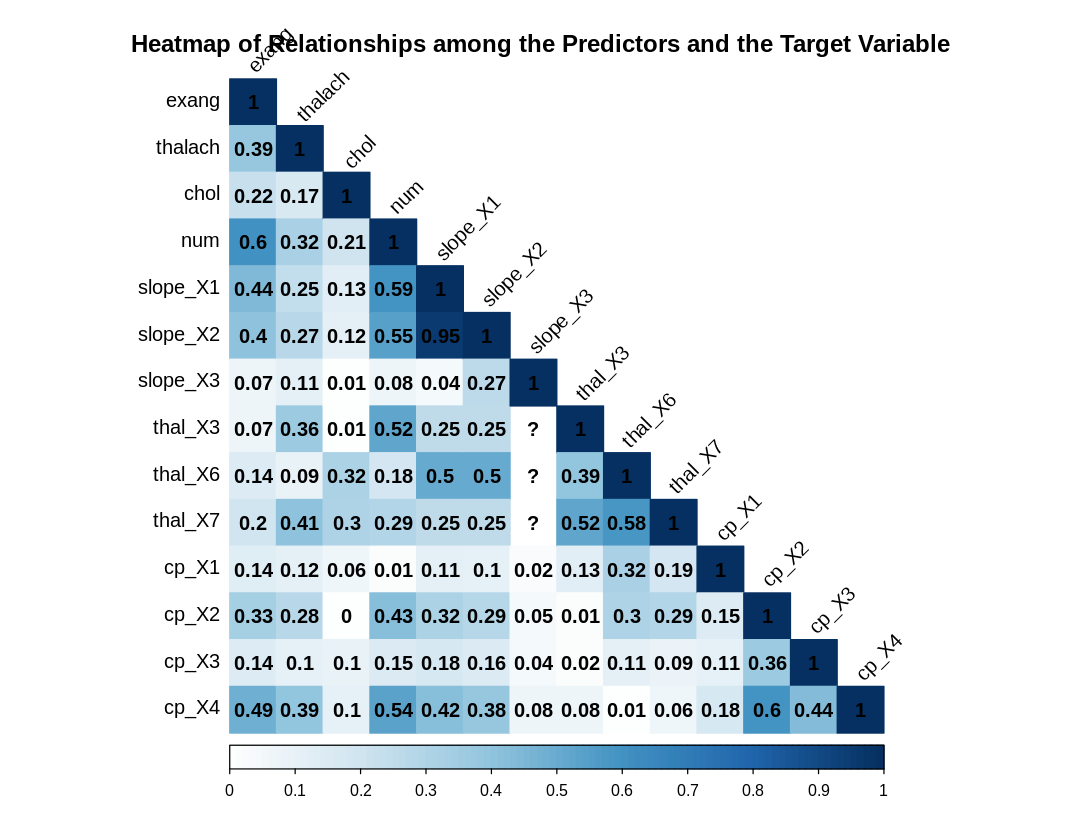

In [28]:
p_cols <- c("slope", "thal", "cp")
predictors <- c("num", "exang", "slope", "thal", "cp", "thalach", "chol")

selected_predictor_train <- heart_disease_train |> select(all_of(predictors))
p_recipe <- recipe(num ~ ., data = selected_predictor_train) |>
  step_dummy(p_cols, one_hot = TRUE)

# calculating changes from the recipe
heart_prep <- p_recipe |>
    prep()

# applying changes and selects for the wanted columns
# mutates exang, a binary factor, to numeric
predictor_train <- bake(heart_prep, selected_predictor_train) |>
    mutate_if(is.factor, as.character) |>
    mutate_if(is.character, as.numeric)

# creating the heatmap of the new dataframe:
# calculating the correlation matrix, ignoring NAs and applying absolute value to it
corr_matrix <- cor(predictor_train, use = "pairwise.complete.obs") |>
                   abs()

# plotting heatmap from the correlatinal matrix (situated in the lower half, legend limit starts from 0 to 1 since abs value was
# applied, squares colored based on correlation strength, texts are in black, diagonal names are angled at 45 degrees and the R
# values are displayed in black)
corrplot(corr_matrix, type = "lower",col.lim = c(0, 1), method = "color", 
         tl.col = "black", tl.srt =45, addCoef.col = "black", 
         title = "\n\n\nHeatmap of Relationships among the Predictors and the Target Variable")
# the greater the color intensity and value, the greater the correlation

*Figure 1. Heatmap of Relationships among the Predictors and the Target Variable*

The stronger the correlation of each variable with respect to the class variable, num, the better those variables will be at predicting angiographic disease status. From the Table 7, the variables at the top of the correlation matrix data frame will be the best predictors; and from Figure 1, the variables with darker colour shades in the num column will be the best predictors.

It can be concluded that the best predictors for our analysis are:

the top five categorical variables:
- exang
- slope_X1
- slope_X2
- cp_X4
- thal_X3

; and the top two numerical variables:
- thalach
- chol

**Predictor Visualizations**

The relationship of particular predictor variables with the class variable were visualized using several graphs.

**1.** The strongest categorical predictor, exang, was represented using a filled bar plot to show the proportions of presence of exercise induced angina in each diagnosis category. This graph shows that the majority of people with a negative angiographic heart disease status do not report symptoms of exercise induced angina. On the contrary, approximately 70% of people with a positive angiographic heart disease status do. It can be concluded that people experiencing exercise induced angina generally will be diagnosed with heart disease. This relationship is moderate to strong, thus, exang will be a good predictor for the model.

**2.** The strongest numerical predictor, thalach, was plotted against the class variable of num in a density plot to visualize their degree of correlation. This graph demonstrates the degree of correlation by how much each variable overlaps with each other. The area of overlap is quite large which indicates that the value of maximum heart rate that patients can achieve is a good indicator of angiographic heart disease status.

**3.** The second strongest numerical predictor, chol, was plotted against the class variable of num in a density plot to visualize their degree of correlation. Although the degree of correlation between these variables is not as significant as thalach with num, the area of overlap on the graph is still notable.

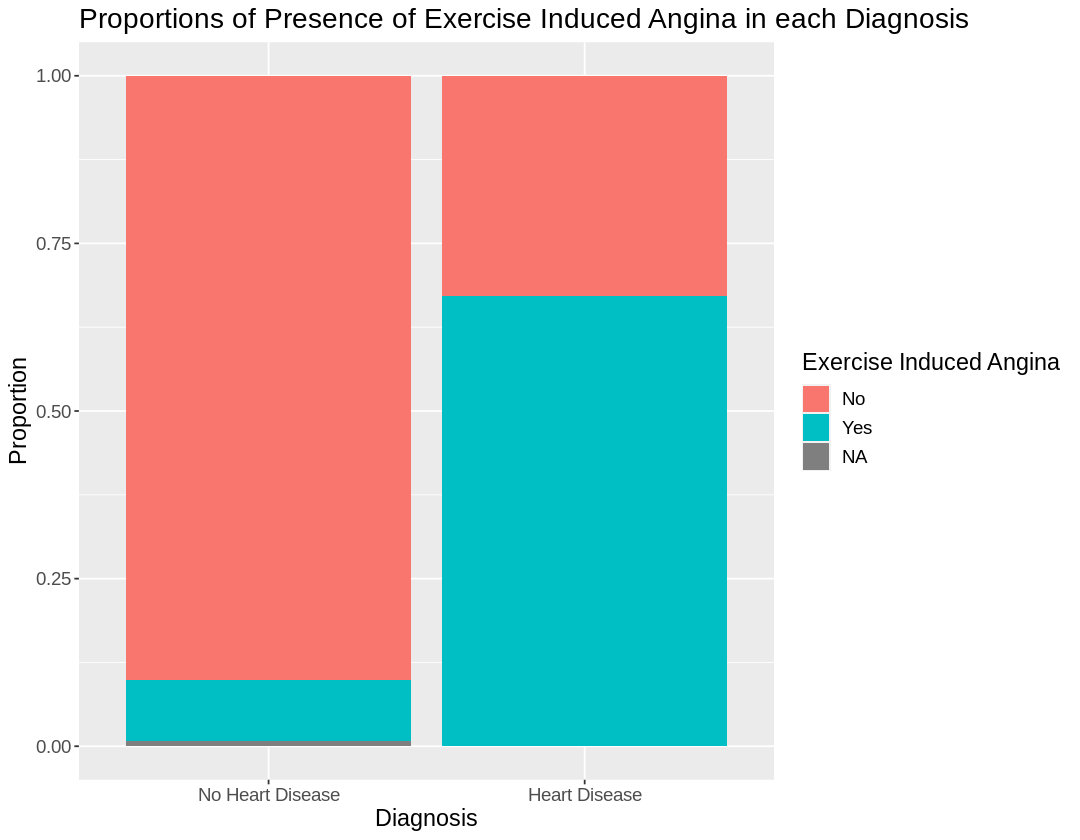

In [29]:
ggplot(predictor_train, aes(x = as.factor(num), fill = factor(exang))) +
  geom_bar(position = "fill") +
  labs(x = "Diagnosis", y = "Proportion", 
       title = "Proportions of Presence of Exercise Induced Angina in each Diagnosis",
       fill = "Exercise Induced Angina") +
  theme(text = element_text(size = 14)) +
  scale_fill_manual(values = c("#F8766D", "#00BFC4"), 
                    name = "Exercise Induced Angina",
                    labels = c("No", "Yes")) +
  scale_x_discrete(labels = c("No Heart Disease", "Heart Disease"))

*Figure 2. Proportions of Presence of Exercise Induced Angina in each Diagnosis*

Warning message:
“Removed 1 rows containing non-finite values (stat_density).”


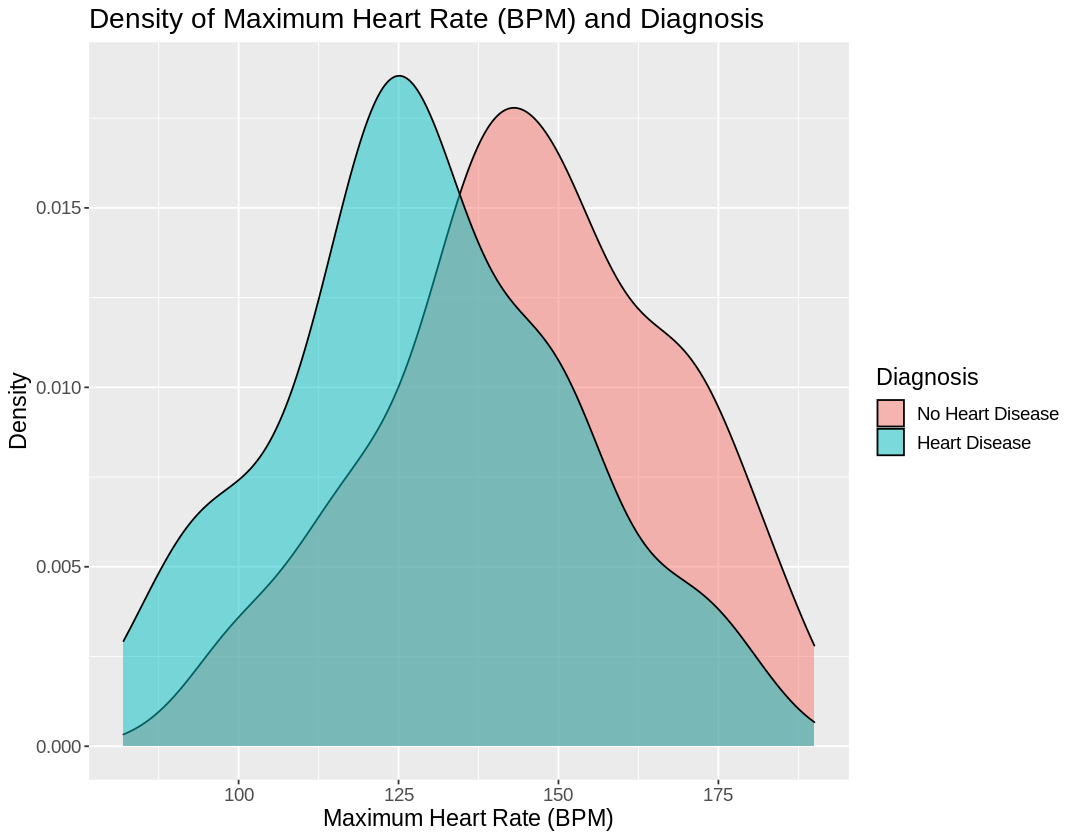

In [21]:
ggplot(predictor_train, aes(x = thalach, fill = factor(num))) +
  geom_density(alpha = 0.5) +
  labs(x = "Maximum Heart Rate (BPM)", y = "Density", 
       title = "Density of Maximum Heart Rate (BPM) and Diagnosis",
       fill = "Diagnosis") +
  scale_fill_manual(values = c("#F8766D", "#00BFC4"),
                    name = "Diagnosis",
                    labels = c("No Heart Disease", "Heart Disease")) +
  theme(text = element_text(size = 14))

*Figure 3. Degree of Overlap of Maximum heart rate (BPS) and Diagnosis*

Warning message:
“Removed 15 rows containing non-finite values (stat_density).”


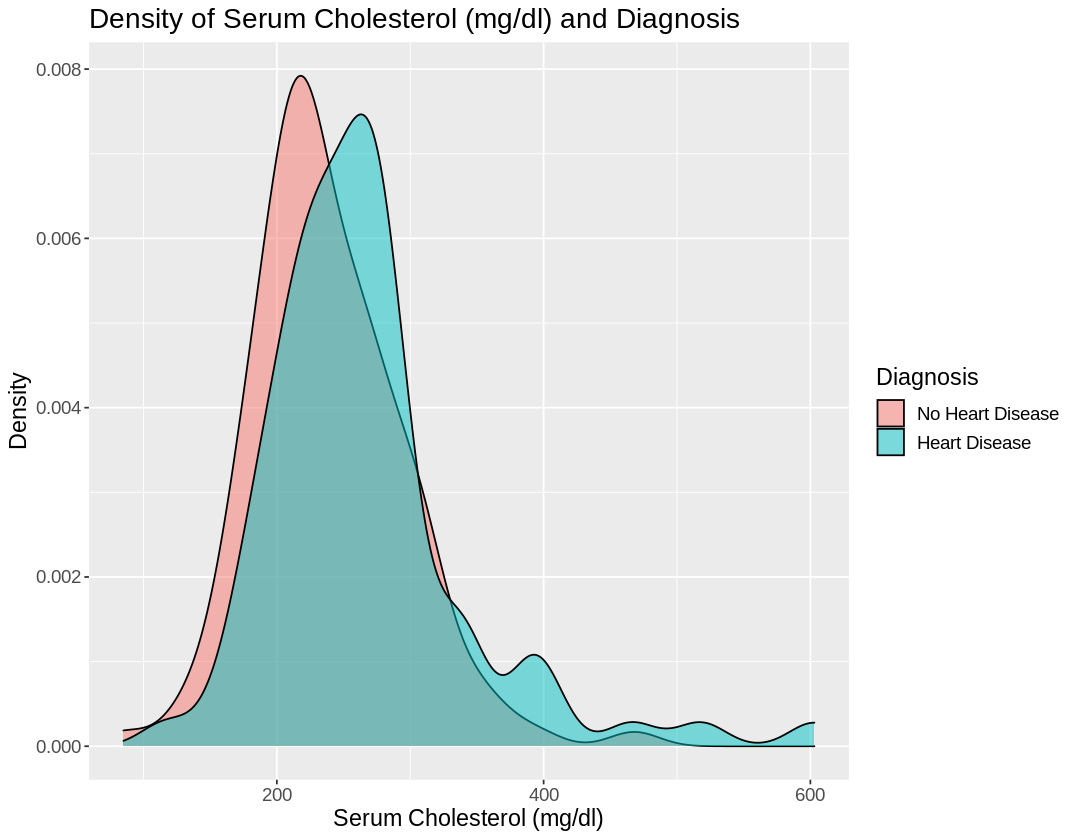

In [22]:
ggplot(predictor_train, aes(x = chol, fill = factor(num))) +
  geom_density(alpha = 0.5) +
  labs(x = "Serum Cholesterol (mg/dl)", y = "Density", 
       title = "Density of Serum Cholesterol (mg/dl) and Diagnosis",
       fill = "Diagnosis") +
  scale_fill_manual(values = c("#F8766D", "#00BFC4"),
                    name = "Diagnosis",
                    labels = c("No Heart Disease", "Heart Disease")) +
  theme(text = element_text(size = 14))

*Figure 4. Degree of Overlap of the Serum Cholesterol (mg/dl) and Diagnosis*

**Developing the classification algorithm:**

In [30]:
set.seed(3789)
#Vector of factor coloumns that have >2 levels
factor_cols <- c("slope", "thal", "cp")
#Predictors + target variable
useful <- c("num", "exang", "slope_X1", "slope_X2", "cp_X4", "thal_X3", "chol", "thalach")


#Define a function to calculate the mode
mode <- function(x) {
  ux <- unique(x)
  ux[which.max(tabulate(match(x, ux)))]
}

#Impute missing values with the mean for double columns and mode for factor columns in heart_disease_train
heart_disease_train_imputed <- heart_disease_train |>
  mutate(across(where(is.numeric), ~replace_na(., mean(., na.rm = TRUE)))) |>
  mutate(across(where(is.factor), ~replace_na(., mode(na.omit(.)))))

#Impute missing values with the mean for double columns and mode for factor columns in heart_disease_test
heart_disease_test_imputed <- heart_disease_test |>
  mutate(across(where(is.numeric), ~replace_na(., mean(., na.rm = TRUE)))) |>
  mutate(across(where(is.factor), ~replace_na(., mode(na.omit(.)))))

#Recipe that creates dummies for all objects in factor cols
heart_pre_recipe <- recipe(num ~ ., data = heart_disease_train_imputed) |>
  step_dummy(factor_cols, one_hot = TRUE)

#Calculates changes
heart_prep <- heart_pre_recipe |> prep()

#Applies changes and selects for the wanted columns. Mutates exang(Binary factor) to numeric.
heart_train_processed <- bake(heart_prep, heart_disease_train_imputed) |> select(useful) |> mutate(exang=as.numeric(exang))
heart_test_processed <- bake(heart_prep, heart_disease_test_imputed) |> select(useful) |> mutate(exang=as.numeric(exang))

heart_recipe <- recipe(num ~ ., data = heart_train_processed) |>
  step_scale(chol, thalach) |>
  step_center(chol, thalach)

knn_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = tune()) |>
  set_engine("kknn") |>
  set_mode("classification") 

k_vals <- tibble(neighbors = seq(from = 1, to = 25, by = 1))
heart_vfold <- vfold_cv(heart_train_processed, v = 5, strata = num)

knn_results <- workflow() |>
  add_recipe(heart_recipe) |>
  add_model(knn_spec) |>
  tune_grid(resamples = heart_vfold, grid = k_vals) |>
  collect_metrics() |>
  filter(.metric == "accuracy") |>
  select(neighbors, mean)

best_k <- knn_results |> filter(mean==max(mean)) |> slice(1) |> pull(neighbors)

best_k
knn_results

[1] 5

neighbors,mean
<dbl>,<dbl>
1,0.7496406
2,0.7496406
3,0.8362391
⋮,⋮
23,0.8314776
24,0.8314776
25,0.8315833


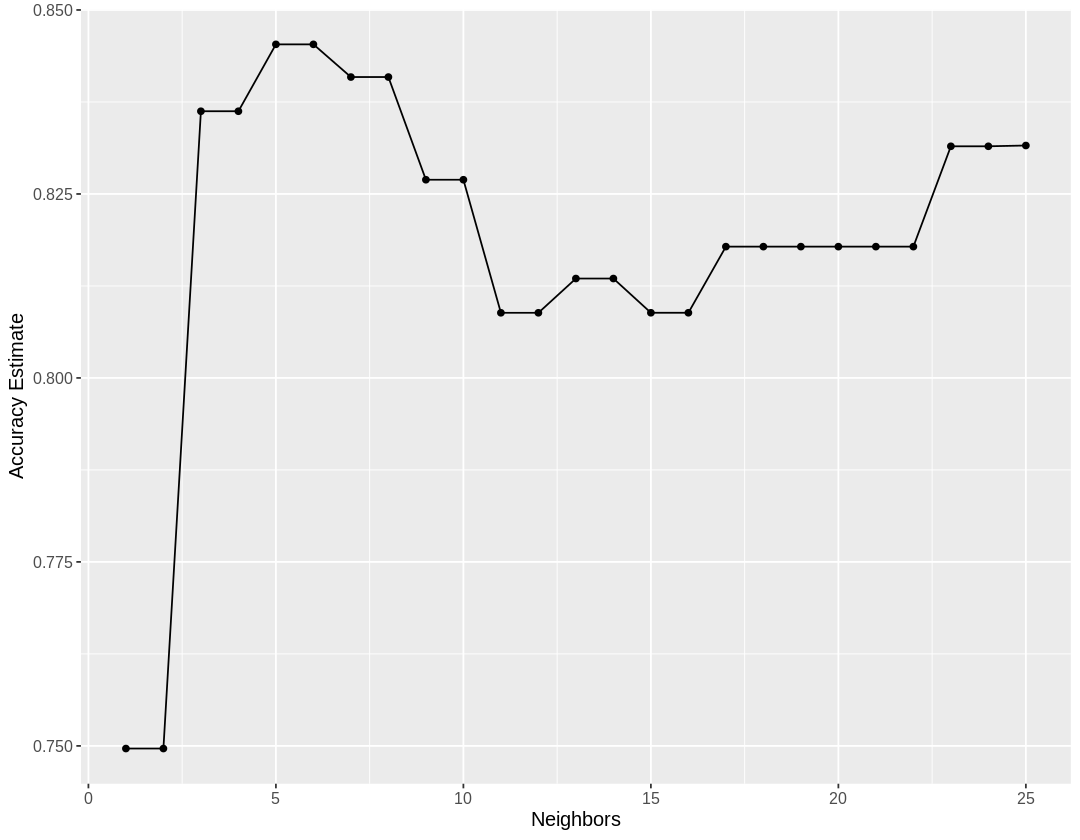

In [31]:
accuracy_vs_k <- knn_results |> ggplot(aes(x = neighbors, y = mean)) +
  geom_point() +
  geom_line() +
  labs(x = "Neighbors", y = "Accuracy Estimate") + 
  theme(text = element_text(size = 12))
accuracy_vs_k

### Results

**Data analysis:**

In [32]:
set.seed(3789)
heart_best_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = best_k) |>
  set_engine("kknn") |>
  set_mode("classification")

heart_fit <- workflow() |>
                  add_recipe(heart_recipe) |>
                  add_model(heart_best_spec) |>
                  fit(data = heart_train_processed)

heart_predictions <- predict(heart_fit , heart_test_processed) |>
       bind_cols(heart_test_processed)

heart_prediction_accuracy <- heart_predictions |>
         metrics(truth = num, estimate = .pred_class)         

heart_prediction_accuracy

.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
accuracy,binary,0.8648649
kap,binary,0.7084318


In [33]:
heart_matrix <- heart_predictions |> 
conf_mat(truth = num, estimate = .pred_class)
heart_matrix

          Truth
Prediction  0  1
         0 42  5
         1  5 22

**Visualization of outcomes:**

Warning message:
“Removed 24 rows containing missing values (geom_point).”


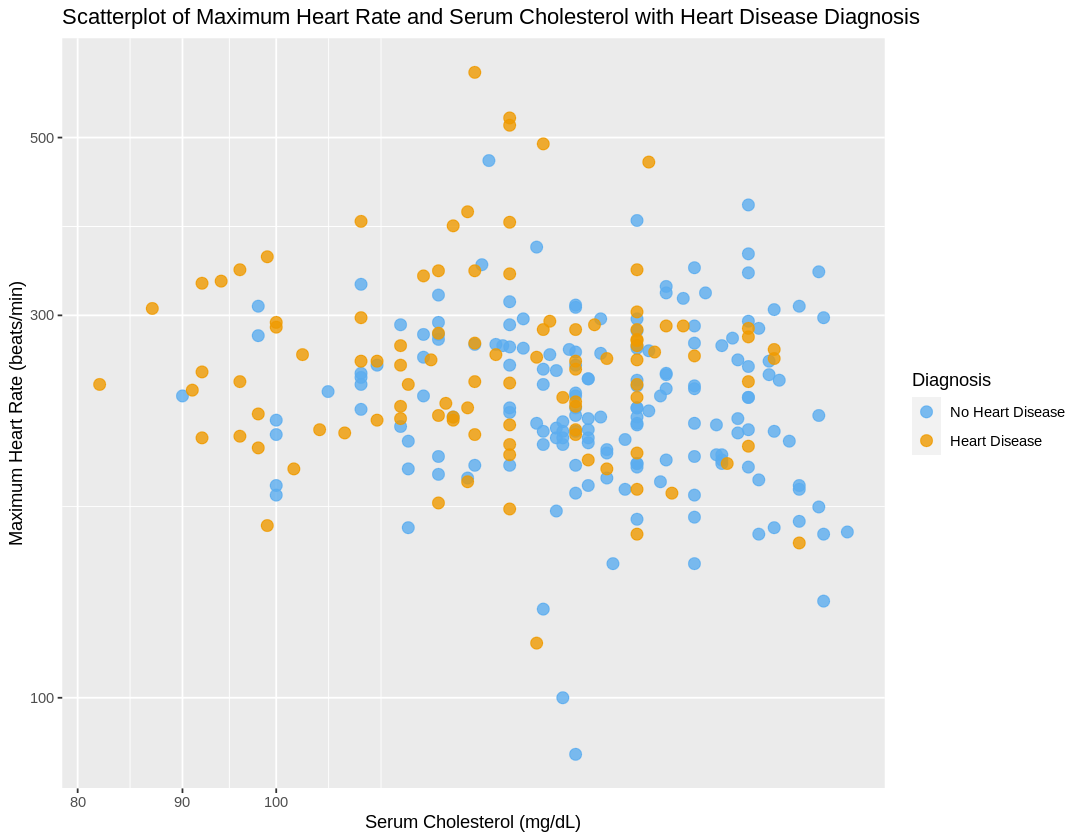

In [34]:
# scatterplot of the predictor variables maximum heart rate (BPS) and serum cholesterol (mg/dl) with diagnosis clustering identification
# variables were chosen from correlation analysis
ggplot(heart_disease_data, aes(x = thalach, y = chol, color = num)) +
  geom_point(size = 3, alpha = 0.8) +
  labs(x = "Serum Cholesterol (mg/dL)", y = "Maximum Heart Rate (beats/min)", 
       color = "Heart Disease Diagnosis") +
  scale_color_manual(values = c("steelblue2", "orange2"), 
                     name = "Diagnosis", 
                     labels = c("No Heart Disease", "Heart Disease")) +
  theme(text = element_text(size = 11)) +
  scale_x_log10(labels = comma) +
  scale_y_log10(labels = comma) +
  ggtitle("Scatterplot of Maximum Heart Rate and Serum Cholesterol with Heart Disease Diagnosis")

### References

CDC: Centers for Disease Control and Prevention. (2022). Heart Disease and Stroke.
https://www.cdc.gov/chronicdisease/resources/publications/factsheets/heart-disease-stroke.htm#:~:text=Leading%20risk%20factors%20for%20heart,unhealthy%20diet%2C%20and%20physical%20inactivity.

Hungarian Institute of Cardiology. (1988). Heart Disease Data Set [Dataset]. UCI Machine Learning 
Repository. https://archive.ics.uci.edu/ml/datasets/Heart+Disease

McLaren. (2023). Heart Disease. 
https://www.mclaren.org/main/heart-disease-risk-factors#:~:text=The%20%22uncontrollable%22%20risk%20factors%20are,and%20common%20lifestyles%20increase%20risk)

OECD and World Health Organization (WHO). (2021). State of health in the EU: Country Health Profile 
2017 - Hungary. https://www.euro.who.int/__data/assets/pdf_file/0006/355983/Health-Profile-Hungary-Eng.pdf